# Deep Learning: common issues and solutions

In [1]:
try:
 from jyquickhelper import add_notebook_menu 
except:
 !pip install jyquickhelper
 from jyquickhelper import add_notebook_menu
    
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
    
def history_to_plot(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    pl.show()


def evaluate_the_model(model, X_test_encoded, y_test):
    y_pred_encoded = model.predict(X_test_encoded)
    y_pred = np.argmax(y_pred_encoded, axis=1) + 1

    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), annot=True)

## 1. Today lab

In this lab we use part of the 'Amazon_Unlocked_Mobile.csv' dataset published by Kaggle. The dataset contain the following information:
* Product Name
* Brand Name
* Price
* Rating
* Reviews
* Review Votes

We are mainly interested by the 'Reviews' (X) and by the 'Rating' (y)

As you did in the previous lab, the goal is to try to predict the 'Rating' after reading the 'Reviews'.
We will mostly use this dataset as a case study to illustrate issues that you can have using Multilayer Perceptron or other Deep Learning architectures, namely:

1) **The vanishing gradient problem**:

Problem: Your model does not learn at all !
Possible solutions, obviously with their pros and cons: 

 - Reduce the depth of your network.
 - Use sparsity promoting activation functions such as the ReLU activation function, i.e ReLU(x)= max(0, x)
 - Use residual connections, i.e output at each layer: layer(input) + input
 - Use normalization techniques, e.g Batch Normalization and so on.
 
2) **Underfitting and Overfitting problems**
Problems:

 - Underfitting relates to the fact that your model does not learn enough on the train dataset to hope for good generalization abilities (good label prediction on new samples with unknown labels).
 - Overfitting means that your model fits too much to the train dataset, which can also prevents it from generalizing well to new samples with unknown labels.
 
 
Possible solutions to underfitting:

 - Increase the network capacity, like creating a deeper and/or wider architecture.

Possible solutions to overfitting:
 
 - Naturally, reduce the network capacity by decreasing its number of parameters.
 - Explicit regularization: Constrain the parameters of your network, for instance by adding their euclidean norm to the objective loss function to minimize. (L2 Regularization)
 - Implicit regularization: Use Dropout Layers which deactivate parts of your network, uniformly at random, at each iteration.
 


In [2]:
add_notebook_menu()

## 2. Dataset pre-processing

In this lab, we will just re-use the dataset of previous lab providing Sentiment Analysis tasks. 
And we will stick to the tf-idf approach for word embeddings. 

In [3]:
import pandas as pd
import numpy as np
import nltk
import pylab as pl # package inheriting most of matplotlib package functions with shorter syntax 
import seaborn as sns

#nltk.download('popular')

### a) Essential reminder [About Train, validation and test sets](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7)
![test/train/val](https://miro.medium.com/max/1466/1*aNPC1ifHN2WydKHyEZYENg.png)

* **Training Dataset:** The sample of data used to fit the model.
* **Validation Dataset:** The sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. The evaluation becomes more biased as skill on the validation dataset is incorporated into the model configuration.
* **Test Dataset:** The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

In [4]:
TRAIN = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/train.csv.gz")
VAL = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/val.csv.gz")
TEST = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/test.csv.gz")

TRAIN.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,Samsung Galaxy Note 4 N910C Unlocked Cellphone...,Samsung,449.99,4,I love it!!! I absolutely love it!! 👌👍,0.0
1,BLU Energy X Plus Smartphone - With 4000 mAh S...,BLU,139.00,5,I love the BLU phones! This is my second one t...,4.0
2,Apple iPhone 6 128GB Silver AT&T,Apple,599.95,5,Great phone,1.0
3,BLU Advance 4.0L Unlocked Smartphone -US GSM -...,BLU,51.99,4,Very happy with the performance. The apps work...,2.0
4,Huawei P8 Lite US Version- 5 Unlocked Android ...,Huawei,198.99,5,Easy to use great price,0.0


### b) Build X (features vectors) and y (labels)

In [5]:
# Construct X_train and y_train
X_train = TRAIN['Reviews'].fillna("")
y_train = TRAIN['Rating']
X_train.shape, y_train.shape

((5000,), (5000,))

In [6]:
# Construct X_val and y_val
X_val = VAL['Reviews'].fillna("")
y_val = VAL['Rating']
X_val.shape, y_val.shape

((1000,), (1000,))

In [7]:
# Construct X_test and y_test
X_test = TEST['Reviews'].fillna("")
y_test = TEST['Rating']
X_test.shape, y_test.shape

((1000,), (1000,))

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

In [9]:
ohe = OneHotEncoder(handle_unknown='ignore')
y_train_encoded = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_val_encoded = ohe.transform(np.array(y_val).reshape(-1, 1)).toarray()
y_test_encoded = ohe.transform(np.array(y_test).reshape(-1, 1)).toarray()

In [10]:
# Encode X_train using TF-IDF 

tfidf = TfidfVectorizer()
tfidf.fit(X_train)
X_train_encoded = tfidf.transform(X_train).toarray()
X_val_encoded = tfidf.transform(X_val).toarray()
X_test_encoded = tfidf.transform(X_test).toarray()

In [11]:
# Define constant
n_classes = len(np.unique(y_train))

feature_vector_length = X_train_encoded.shape[1]

## 3. Vanishing gradient problem

This problem can be encountered when training NN with gradient-based learning methods and backpropagation. In such methods, during each iteration of training each of the neural network's weights receives an update proportional to the partial derivative of the loss function with respect to the current weight. The problem is that in some cases, the gradient will be vanishingly small, effectively preventing the weight from changing its value. This mostly occurs when your architecture counts too many parameters to learn.

### a) Observe the vanishing gradient problem

[ TO DO STUDENTS]

Design a function to simply build MLP with the following inputs, which return the model ready to compile:

 - activation: activation used at each hidden layer 
 - n_hiddenlayers: number of hidden layers in the network
 - hidden_dim: shared number of neurons within each hidden layer 

In [12]:
def build_model(inp_size, nb_classes, activation, n_layers, hidden_dim) -> Model:
    input = Input(shape=(inp_size, ))

    for i in range(n_layers):
        if i == 0:
            x = Dense(input_shape=(inp_size,), units=hidden_dim,
                      activation=activation)(input)
        else:
            x = Dense(input_shape=(hidden_dim,),
                      units=hidden_dim, activation=activation)(x)

    output = Dense(input_shape=(hidden_dim,),
                   units=nb_classes, activation="softmax")(x)
    model = Model(input, output, name='model_' + activation)
    return model

In [13]:
# Build a network with 10 hidden layers with 'tanh' activations
n_hiddenlayers = 30
activation = 'tanh'
hidden_dim = 256
model = build_model(feature_vector_length, n_classes, activation, n_hiddenlayers, hidden_dim)

# Print the model
model.summary()

Model: "model_tanh"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8991)]            0         
                                                                 
 dense (Dense)               (None, 256)               2301952   
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 256)               6

In [14]:
# Configure the model and start training
# Stop training with early stopping with patience of 20
callbacks_list = [
    EarlyStopping(
        monitor='val_accuracy', 
        min_delta=0.0005, 
        patience=20, 
        verbose=1, 
        mode='max', 
        restore_best_weights=True)]

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_encoded, y_train_encoded, validation_data=(X_val_encoded, y_val_encoded),
 epochs=100, batch_size=250, callbacks=callbacks_list, verbose=1)

Epoch 1/100
20/20 [==============================] - 4s 108ms/step - loss: 1.5453 - accuracy: 0.4672 - val_loss: 1.3172 - val_accuracy: 0.5590
Epoch 2/100
20/20 [==============================] - 1s 57ms/step - loss: 1.3057 - accuracy: 0.5384 - val_loss: 1.2687 - val_accuracy: 0.5590
Epoch 3/100
20/20 [==============================] - 1s 54ms/step - loss: 1.3065 - accuracy: 0.5384 - val_loss: 1.2611 - val_accuracy: 0.5590
Epoch 4/100
20/20 [==============================] - 1s 59ms/step - loss: 1.3074 - accuracy: 0.5384 - val_loss: 1.2723 - val_accuracy: 0.5590
Epoch 5/100
20/20 [==============================] - 1s 58ms/step - loss: 1.2942 - accuracy: 0.5384 - val_loss: 1.2675 - val_accuracy: 0.5590
Epoch 6/100
20/20 [==============================] - 1s 58ms/step - loss: 1.2989 - accuracy: 0.5384 - val_loss: 1.2916 - val_accuracy: 0.5590
Epoch 7/100
20/20 [==============================] - 1s 56ms/step - loss: 1.3014 - accuracy: 0.5384 - val_loss: 1.2604 - val_accuracy: 0.5590
Epoch

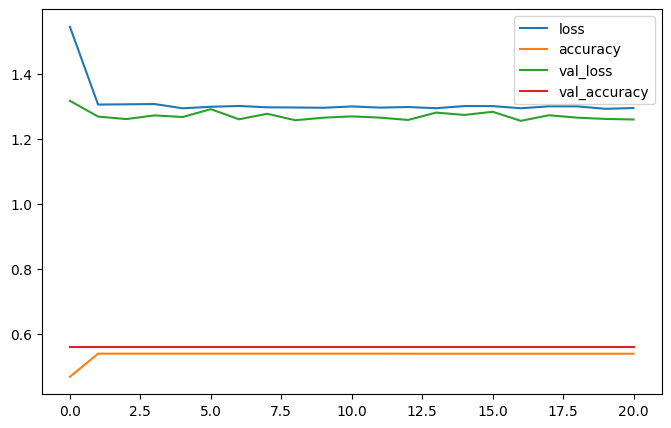

In [15]:
# Plot the learning curves and analyze them
history_to_plot(history)

32/32 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       159
           2       0.00      0.00      0.00        51
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00       163
           5       0.56      1.00      0.71       556

    accuracy                           0.56      1000
   macro avg       0.11      0.20      0.14      1000
weighted avg       0.31      0.56      0.40      1000



c:\Users\DavideF\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\DavideF\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\DavideF\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

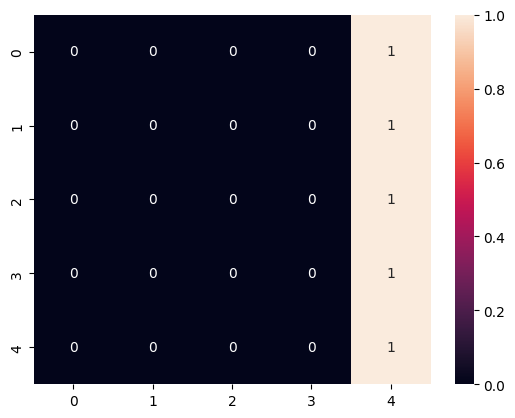

In [16]:
# Evaluate the model

evaluate_the_model(model, X_test_encoded, y_test)

___
From the plot, we see that tanh with 30 layers stop to learn after the first epoch
___

### b) Experiment on ReLU activation

Change activation from 'tanh' to 'relu', still with a deep network.

In [17]:
# Build a network with 10 hidden layers with 'tanh' activations
n_hiddenlayers = 30
activation = 'relu'
hidden_dim = 256
model = build_model(feature_vector_length, n_classes, activation, n_hiddenlayers, hidden_dim)

# Print the model
model.summary()

Model: "model_relu"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8991)]            0         
                                                                 
 dense_31 (Dense)            (None, 256)               2301952   
                                                                 
 dense_32 (Dense)            (None, 256)               65792     
                                                                 
 dense_33 (Dense)            (None, 256)               65792     
                                                                 
 dense_34 (Dense)            (None, 256)               65792     
                                                                 
 dense_35 (Dense)            (None, 256)               65792     
                                                                 
 dense_36 (Dense)            (None, 256)               6

In [19]:
# Configure the model and start training
patience = 10
callbacks_list = [EarlyStopping(monitor='val_accuracy', min_delta=0.0005, patience=20, verbose=1, mode='max', restore_best_weights=True)]

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_encoded, y_train_encoded, validation_data=(X_val_encoded, y_val_encoded),
 epochs=50, batch_size=250, callbacks=callbacks_list, verbose=1)

Epoch 1/50
20/20 [==============================] - 4s 102ms/step - loss: 0.8773 - accuracy: 0.7012 - val_loss: 1.1469 - val_accuracy: 0.6760
Epoch 2/50
20/20 [==============================] - 1s 57ms/step - loss: 0.4817 - accuracy: 0.8082 - val_loss: 1.1563 - val_accuracy: 0.5950
Epoch 3/50
20/20 [==============================] - 1s 51ms/step - loss: 0.3532 - accuracy: 0.8776 - val_loss: 2.1329 - val_accuracy: 0.6150
Epoch 4/50
20/20 [==============================] - 1s 49ms/step - loss: 0.2531 - accuracy: 0.9102 - val_loss: 2.5876 - val_accuracy: 0.5720
Epoch 5/50
20/20 [==============================] - 1s 53ms/step - loss: 0.2146 - accuracy: 0.9384 - val_loss: 2.9655 - val_accuracy: 0.5790
Epoch 6/50
20/20 [==============================] - 1s 51ms/step - loss: 0.2216 - accuracy: 0.9340 - val_loss: 2.9695 - val_accuracy: 0.5800
Epoch 7/50
20/20 [==============================] - 1s 51ms/step - loss: 0.2152 - accuracy: 0.9310 - val_loss: 2.4874 - val_accuracy: 0.5690
Epoch 8/50
2

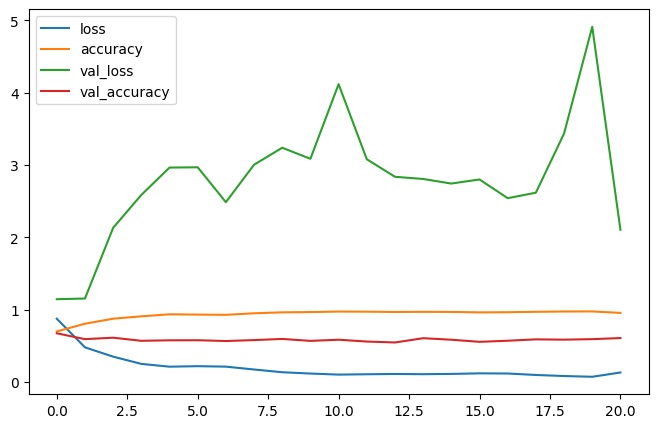

32/32 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

           1       0.60      0.82      0.69       159
           2       0.00      0.00      0.00        51
           3       0.28      0.15      0.20        71
           4       0.34      0.13      0.19       163
           5       0.76      0.93      0.84       556

    accuracy                           0.68      1000
   macro avg       0.39      0.41      0.38      1000
weighted avg       0.59      0.68      0.62      1000



c:\Users\DavideF\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\DavideF\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\DavideF\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

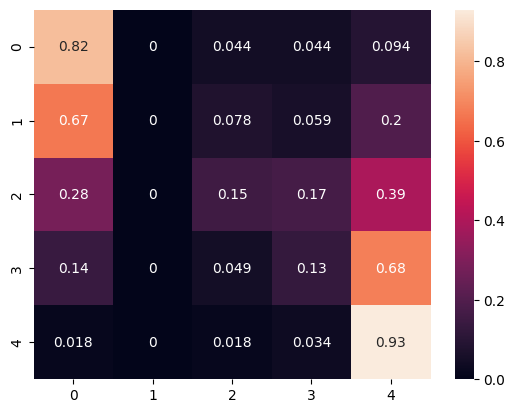

In [20]:
# Plot the learning curves and analyze them
# Evaluate the model

history_to_plot(history)
evaluate_the_model(model, X_test_encoded, y_test)

Here it seems that the sparsity promoting ReLU activation helped towards solving the problem but the model still struggle to learn and to achieve good performances on the validation set.

### c) Experiment on residual connections

[ TO STUDENTS ]
- Create a function to generate models with residual connections.
- Using tanh activation + residual connections, are you able to get better results ?
- Provide here a description of the learning and performances of your network
- Compare it to previous models. What are your conclusions ?

In [21]:
def build_residual_model(inp_size, nb_classes, activation, n_layers, hidden_dim) -> Model:
    input = Input(shape=(inp_size, ))
    
    for i in range(n_layers):
        if i == 0:
            x = Dense(input_shape=(inp_size,), units=hidden_dim,
                      activation=activation)(input)
        else:
            y = Dense(input_shape=(hidden_dim,),
                      units=hidden_dim, activation=activation)(x)
            x = y + x

    output = Dense(input_shape=(hidden_dim,),
                   units=nb_classes, activation="softmax")(x)
    model = Model(input, output, name='model_' + activation)
    return model

In [22]:
n_hiddenlayers = 30
activation = 'tanh'
hidden_dim = 256
model = build_residual_model(feature_vector_length, n_classes, activation, n_hiddenlayers, hidden_dim)

# Print the model
model.summary()

Model: "model_tanh"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 8991)]       0           []                               
                                                                                                  
 dense_62 (Dense)               (None, 256)          2301952     ['input_3[0][0]']                
                                                                                                  
 dense_63 (Dense)               (None, 256)          65792       ['dense_62[0][0]']               
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 256)         0           ['dense_63[0][0]',               
 da)                                                              'dense_62[0][0]']      

In [23]:
# Configure the model and start training
patience = 10
callbacks_list = [
    EarlyStopping(
        monitor='val_accuracy', 
        min_delta=0.0005, 
        patience=20, verbose=1, 
        mode='max', 
        restore_best_weights=True)]

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_encoded, y_train_encoded, validation_data=(X_val_encoded, y_val_encoded),
 epochs=50, batch_size=250, callbacks=callbacks_list, verbose=1)

Epoch 1/50
20/20 [==============================] - 4s 83ms/step - loss: 7.6254 - accuracy: 0.3564 - val_loss: 3.5529 - val_accuracy: 0.6020
Epoch 2/50
20/20 [==============================] - 1s 56ms/step - loss: 2.0632 - accuracy: 0.5794 - val_loss: 1.3845 - val_accuracy: 0.5850
Epoch 3/50
20/20 [==============================] - 1s 56ms/step - loss: 1.0570 - accuracy: 0.6690 - val_loss: 1.1597 - val_accuracy: 0.6080
Epoch 4/50
20/20 [==============================] - 1s 62ms/step - loss: 0.7520 - accuracy: 0.7320 - val_loss: 1.2164 - val_accuracy: 0.6300
Epoch 5/50
20/20 [==============================] - 1s 57ms/step - loss: 0.5395 - accuracy: 0.8090 - val_loss: 1.2539 - val_accuracy: 0.6330
Epoch 6/50
20/20 [==============================] - 1s 71ms/step - loss: 0.3587 - accuracy: 0.8770 - val_loss: 1.4165 - val_accuracy: 0.6550
Epoch 7/50
20/20 [==============================] - 1s 57ms/step - loss: 0.2711 - accuracy: 0.9074 - val_loss: 1.5262 - val_accuracy: 0.6260
Epoch 8/50
20

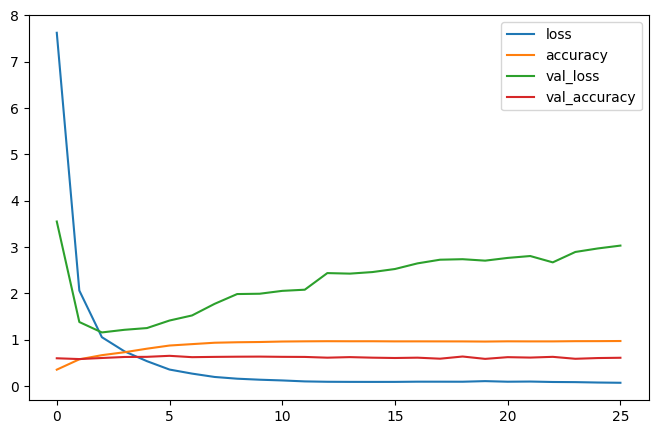

In [24]:
# Plot the learning curves and analyze them
history_to_plot(history)

32/32 [==============================] - 1s 11ms/step
              precision    recall  f1-score   support

           1       0.64      0.65      0.64       159
           2       0.22      0.25      0.23        51
           3       0.08      0.03      0.04        71
           4       0.33      0.27      0.30       163
           5       0.78      0.87      0.83       556

    accuracy                           0.65      1000
   macro avg       0.41      0.41      0.41      1000
weighted avg       0.61      0.65      0.62      1000



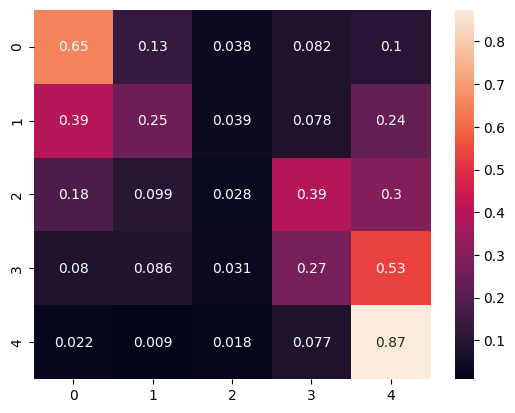

In [25]:
# Evaluate the model
evaluate_the_model(model, X_test_encoded, y_test)

### d) Experiment on Batch Normalization

[ TO STUDENTS ]
- adapt functions build_model and build_residual_model to add batch normalization layers after the output of the hidden dense layers. 
- Using tanh activation + batch normalization
- Then using tanh activation + batch normalization + residual connections
- Compare your results

In [26]:
from keras.layers import BatchNormalization

In [27]:
def build_model_V2(inp_size, nb_classes, activation, n_layers, hidden_dim) -> Model:
    input = Input(shape=(inp_size, ))

    for i in range(n_layers):
        if i == 0:
            x = Dense(input_shape=(inp_size,), units=hidden_dim,
                      activation=activation)(input)
        else:
            y = Dense(input_shape=(hidden_dim,),
                      units=hidden_dim, activation=activation)(x)
            y = BatchNormalization()(y)
            x = x + y
    
    output = Dense(input_shape=(hidden_dim,),
                   units=nb_classes, activation="softmax")(x)
    model = Model(input, output, name='model_' + activation)
    return model

In [28]:
def build_residual_model_V2(inp_size, nb_classes, activation, n_layers, hidden_dim) -> Model:
    input = Input(shape=(inp_size, ))

    for i in range(n_layers):
        if i == 0:
            x = Dense(input_shape=(inp_size,), units=hidden_dim,
                      activation=activation)(input)
        else:
            y = Dense(input_shape=(hidden_dim,),
                      units=hidden_dim, activation=activation)(x)
            y = BatchNormalization()(y)
            x = x + y

    output = Dense(input_shape=(hidden_dim,),
                   units=nb_classes, activation="softmax")(x)
    model = Model(input, output, name='model_' + activation)
    return model

In [29]:
#Build and train the network without residual connections
n_hiddenlayers = 30
activation = 'tanh'
hidden_dim = 256
model = build_model_V2(feature_vector_length, n_classes, activation, n_hiddenlayers, hidden_dim)

# Print the model
model.summary()
# Configure the model and start training
patience = 10
callbacks_list = [EarlyStopping(monitor='val_accuracy', min_delta=0.0005, patience=20, verbose=1, mode='max', restore_best_weights=True)
 ]

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_encoded, y_train_encoded, validation_data=(X_val_encoded, y_val_encoded),
 epochs=50, batch_size=250, callbacks=callbacks_list, verbose=1)

Model: "model_tanh"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 8991)]       0           []                               
                                                                                                  
 dense_93 (Dense)               (None, 256)          2301952     ['input_4[0][0]']                
                                                                                                  
 dense_94 (Dense)               (None, 256)          65792       ['dense_93[0][0]']               
                                                                                                  
 batch_normalization (BatchNorm  (None, 256)         1024        ['dense_94[0][0]']               
 alization)                                                                              

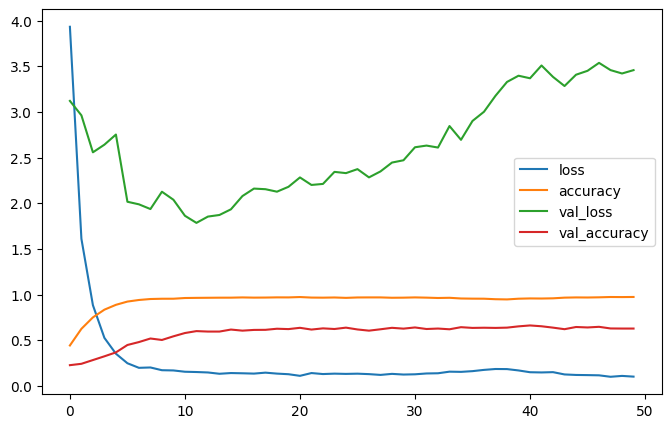

In [30]:
# Plot the learning curves and analyze them
history_to_plot(history)

In [31]:
#Build and train the network with residual connections
n_hiddenlayers = 30
activation = 'tanh'
hidden_dim = 256
patience = 10
model = build_residual_model_V2(feature_vector_length, n_classes, activation, n_hiddenlayers, hidden_dim)

# Print the model
model.summary()
# Configure the model and start training
patience = 10
callbacks_list = [
    EarlyStopping(monitor='val_accuracy', min_delta=0.0005, patience=patience, verbose=1, mode='max', restore_best_weights=True)
 ]

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_encoded, y_train_encoded, validation_data=(X_val_encoded, y_val_encoded),
 epochs=50, batch_size=250, callbacks=callbacks_list, verbose=1)

Model: "model_tanh"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 8991)]       0           []                               
                                                                                                  
 dense_124 (Dense)              (None, 256)          2301952     ['input_5[0][0]']                
                                                                                                  
 dense_125 (Dense)              (None, 256)          65792       ['dense_124[0][0]']              
                                                                                                  
 batch_normalization_29 (BatchN  (None, 256)         1024        ['dense_125[0][0]']              
 ormalization)                                                                           

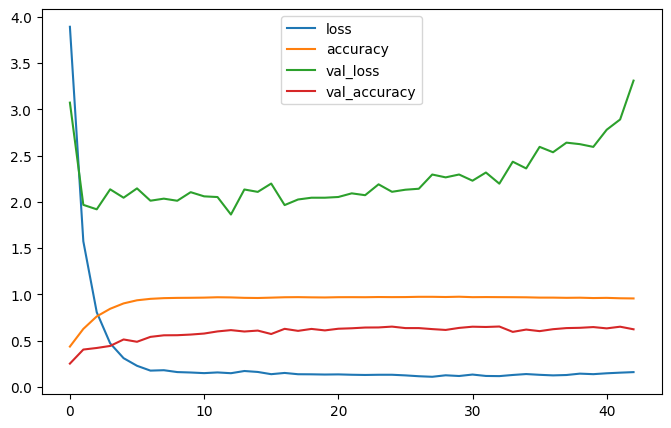

32/32 [==============================] - 1s 16ms/step
              precision    recall  f1-score   support

           1       0.62      0.64      0.63       159
           2       0.19      0.22      0.20        51
           3       0.11      0.06      0.08        71
           4       0.36      0.25      0.29       163
           5       0.76      0.87      0.81       556

    accuracy                           0.64      1000
   macro avg       0.41      0.40      0.40      1000
weighted avg       0.60      0.64      0.61      1000



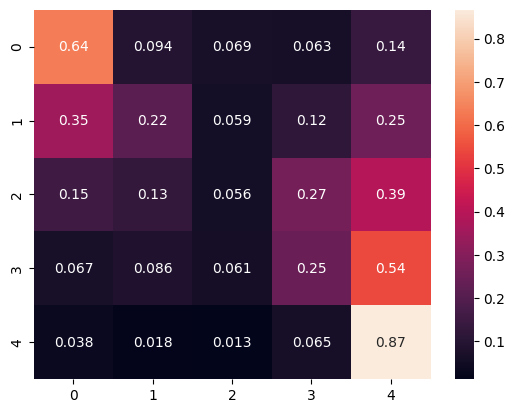

In [32]:
# Plot the learning curves and analyze them
history_to_plot(history)
evaluate_the_model(model, X_test_encoded, y_test)

### e) What if you simply reduce the network depth ?

[ TO DO STUDENTS ]
- build a MLP with tanh activation composed of 10 hidden layers
- compare your results both in terms of learning and performances compared to other model

In [33]:
#Build and train the network without residual connections
n_hiddenlayers = 10
activation = 'tanh'
hidden_dim = 256
model = build_model_V2(feature_vector_length, n_classes, activation, n_hiddenlayers, hidden_dim)

# Print the model
model.summary()
# Configure the model and start training
patience = 10
callbacks_list = [EarlyStopping(monitor='val_accuracy', min_delta=0.0005, patience=20, verbose=1, mode='max', restore_best_weights=True)
 ]

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_encoded, y_train_encoded, validation_data=(X_val_encoded, y_val_encoded),
 epochs=50, batch_size=250, callbacks=callbacks_list, verbose=1)

Model: "model_tanh"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 8991)]       0           []                               
                                                                                                  
 dense_155 (Dense)              (None, 256)          2301952     ['input_6[0][0]']                
                                                                                                  
 dense_156 (Dense)              (None, 256)          65792       ['dense_155[0][0]']              
                                                                                                  
 batch_normalization_58 (BatchN  (None, 256)         1024        ['dense_156[0][0]']              
 ormalization)                                                                           

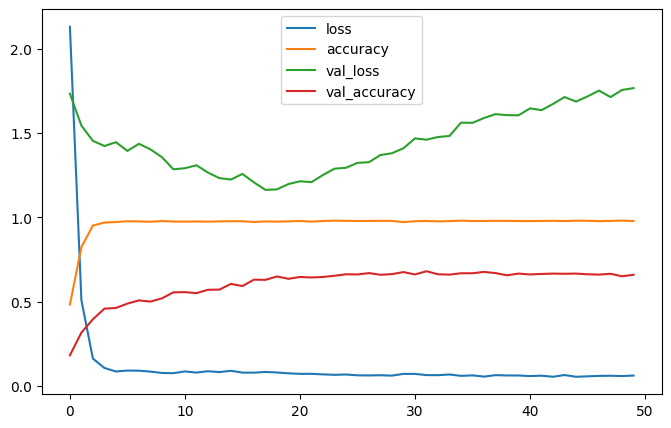

In [34]:
# Plot the learning curves and analyze them
pd.DataFrame(history.history).plot(figsize=(8,5))
pl.show()

32/32 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

           1       0.59      0.72      0.65       159
           2       0.24      0.16      0.19        51
           3       0.20      0.11      0.14        71
           4       0.33      0.29      0.31       163
           5       0.81      0.85      0.83       556

    accuracy                           0.65      1000
   macro avg       0.43      0.43      0.42      1000
weighted avg       0.62      0.65      0.63      1000



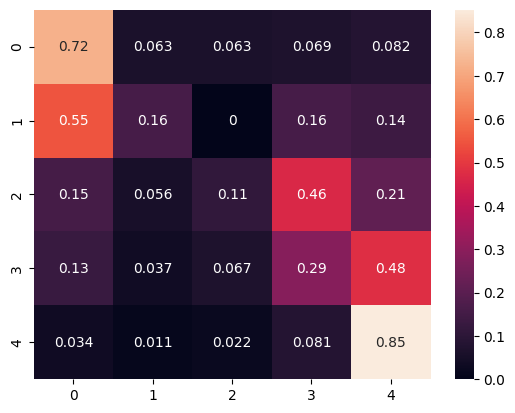

In [35]:
# Evaluate the model
evaluate_the_model(model, X_test_encoded, y_test)

## 4. Underfitting and Overfitting problems

Actually what you observed in the last experiment is a typical instance of overfitting.

### a) Decrease the network size ?

In [36]:
#Build and train the network without residual connections
n_hiddenlayers = 5
activation = 'tanh'
hidden_dim = 256
model = build_model_V2(feature_vector_length, n_classes, activation, n_hiddenlayers, hidden_dim)

# Print the model
model.summary()
# Configure the model and start training
patience = 10
callbacks_list = [EarlyStopping(monitor='val_accuracy', min_delta=0.0005, patience=20, verbose=1, mode='max', restore_best_weights=True)
 ]

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_encoded, y_train_encoded, validation_data=(X_val_encoded, y_val_encoded),
 epochs=50, batch_size=250, callbacks=callbacks_list, verbose=1)

Model: "model_tanh"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 8991)]       0           []                               
                                                                                                  
 dense_166 (Dense)              (None, 256)          2301952     ['input_7[0][0]']                
                                                                                                  
 dense_167 (Dense)              (None, 256)          65792       ['dense_166[0][0]']              
                                                                                                  
 batch_normalization_67 (BatchN  (None, 256)         1024        ['dense_167[0][0]']              
 ormalization)                                                                           

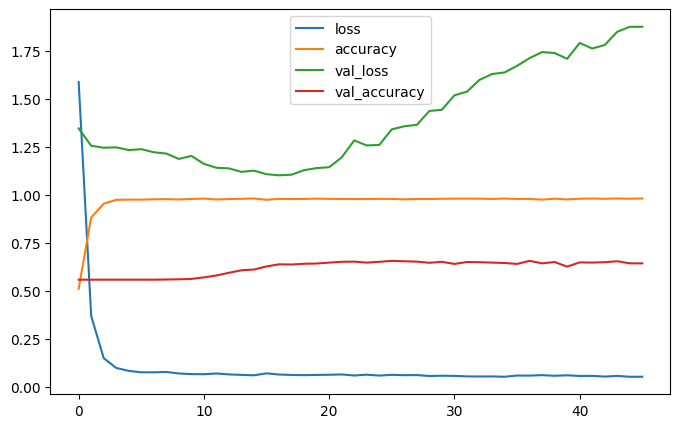

In [37]:
# Plot the learning curves and analyze them
history_to_plot(history)

32/32 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           1       0.64      0.64      0.64       159
           2       0.38      0.12      0.18        51
           3       0.17      0.10      0.12        71
           4       0.32      0.21      0.25       163
           5       0.74      0.90      0.81       556

    accuracy                           0.65      1000
   macro avg       0.45      0.39      0.40      1000
weighted avg       0.60      0.65      0.61      1000



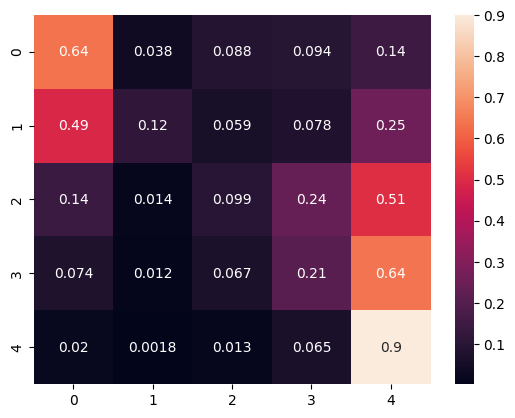

In [38]:
# Evaluate the model
evaluate_the_model(model, X_test_encoded, y_test)

It gets slightly better but almost the same behavior is observed when taking 10 and 5 hidden layers.

### b) Experiment on L2 regularization

[ TO DO STUDENTS ]
- check the keras documentation on regularizations https://keras.io/api/layers/regularizers/
- Add to the previous network L2 regularization: first with l2_reg = 0.01 / then with l2_reg= 0.0001
- Compare results

In [53]:
# Design the model function
# TODO ! 
from tensorflow.keras import regularizers

def build_model_reg(inp_size, nb_classes, activation, n_layers, hidden_dim, l2_reg = 0.01):
    input = Input(shape=(inp_size, ))

    for i in range(n_layers):
        if i == 0:
            x = Dense(input_shape=(inp_size,), units=hidden_dim,
                      activation=activation,
                      kernel_regularizer=regularizers.L2(l2_reg),
                      bias_regularizer=regularizers.L2(l2_reg))(input)
        else:
            y = Dense(input_shape=(hidden_dim,),
                      units=hidden_dim, activation=activation,
                      kernel_regularizer=regularizers.L2(l2_reg),
                      bias_regularizer=regularizers.L2(l2_reg))(x)
            y = BatchNormalization()(y)
            x = x + y

    output = Dense(input_shape=(hidden_dim,),
                   units=nb_classes, activation="softmax")(x)
    model = Model(input, output, name='model_' + activation)
    return model


In [54]:
#Build and train the network without residual connections
n_hiddenlayers = 5
activation = 'tanh'
hidden_dim = 256
epochs = 100
l2_reg = 0.01
model = build_model_reg(feature_vector_length, n_classes,
                        activation, n_hiddenlayers, hidden_dim, l2_reg)

# Print the model
model.summary()

Model: "model_tanh"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 8991)]       0           []                               
                                                                                                  
 dense_184 (Dense)              (None, 256)          2301952     ['input_10[0][0]']               
                                                                                                  
 dense_185 (Dense)              (None, 256)          65792       ['dense_184[0][0]']              
                                                                                                  
 batch_normalization_79 (BatchN  (None, 256)         1024        ['dense_185[0][0]']              
 ormalization)                                                                           

In [55]:
# Configure the model and start training

callbacks_list = [EarlyStopping(monitor='val_accuracy', min_delta=0.0005, patience=20, verbose=1, mode='max', restore_best_weights=True)
 ]

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_encoded, y_train_encoded, validation_data=(X_val_encoded, y_val_encoded),
 epochs=epochs, batch_size=250, callbacks=callbacks_list, verbose=1)

Epoch 1/100
20/20 [==============================] - 3s 82ms/step - loss: 14.3476 - accuracy: 0.5178 - val_loss: 12.6274 - val_accuracy: 0.5590
Epoch 2/100
20/20 [==============================] - 1s 56ms/step - loss: 10.8011 - accuracy: 0.8808 - val_loss: 10.7379 - val_accuracy: 0.5590
Epoch 3/100
20/20 [==============================] - 1s 61ms/step - loss: 8.7844 - accuracy: 0.9552 - val_loss: 8.9590 - val_accuracy: 0.5590
Epoch 4/100
20/20 [==============================] - 1s 55ms/step - loss: 7.0766 - accuracy: 0.9680 - val_loss: 7.4495 - val_accuracy: 0.5590
Epoch 5/100
20/20 [==============================] - 1s 54ms/step - loss: 5.6677 - accuracy: 0.9678 - val_loss: 6.2148 - val_accuracy: 0.5590
Epoch 6/100
20/20 [==============================] - 1s 60ms/step - loss: 4.5769 - accuracy: 0.9518 - val_loss: 5.2896 - val_accuracy: 0.5590
Epoch 7/100
20/20 [==============================] - 1s 49ms/step - loss: 3.8130 - accuracy: 0.9142 - val_loss: 4.6287 - val_accuracy: 0.5590
Ep

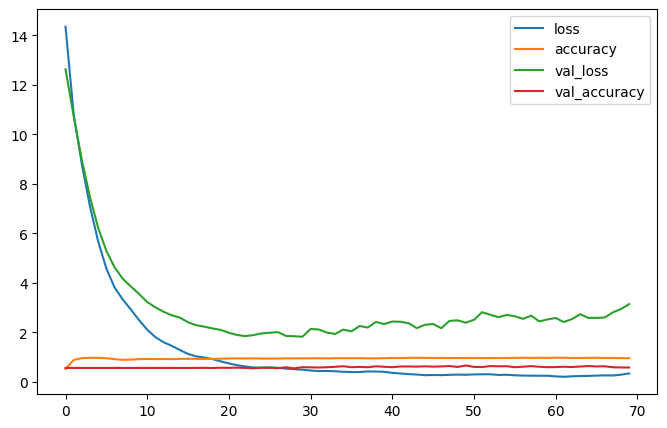

In [56]:
# Plot the learning curves and analyze them
pd.DataFrame(history.history).plot(figsize=(8,5))
pl.show()

32/32 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           1       0.58      0.67      0.62       159
           2       0.29      0.10      0.15        51
           3       0.21      0.23      0.22        71
           4       0.30      0.19      0.23       163
           5       0.76      0.85      0.80       556

    accuracy                           0.63      1000
   macro avg       0.43      0.41      0.40      1000
weighted avg       0.59      0.63      0.60      1000



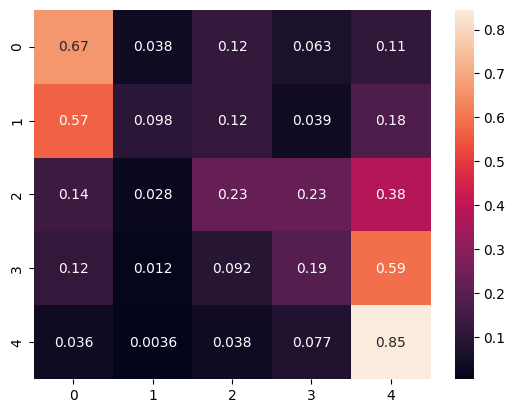

In [57]:
# Evaluate the model
evaluate_the_model(model, X_test_encoded, y_test)

[ TO DO STUDENTS]

Reduce the coefficient of L2 regularization taken into account in the loss from l2_reg = 0.01 > To l2_reg = 0.0001

In [58]:
l2_reg = 0.0001
model = build_model_reg(feature_vector_length, n_classes,
                        activation, n_hiddenlayers, hidden_dim, l2_reg)

# Print the model
model.summary()

Model: "model_tanh"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 8991)]       0           []                               
                                                                                                  
 dense_190 (Dense)              (None, 256)          2301952     ['input_11[0][0]']               
                                                                                                  
 dense_191 (Dense)              (None, 256)          65792       ['dense_190[0][0]']              
                                                                                                  
 batch_normalization_83 (BatchN  (None, 256)         1024        ['dense_191[0][0]']              
 ormalization)                                                                           

In [59]:
# Configure the model and start training

callbacks_list = [EarlyStopping(monitor='val_accuracy', min_delta=0.0005, patience=20, verbose=1, mode='max', restore_best_weights=True)
 ]

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_encoded, y_train_encoded, validation_data=(X_val_encoded, y_val_encoded),
 epochs=epochs, batch_size=250, callbacks=callbacks_list, verbose=1)

Epoch 1/100
20/20 [==============================] - 3s 65ms/step - loss: 1.7164 - accuracy: 0.5060 - val_loss: 1.4498 - val_accuracy: 0.5590
Epoch 2/100
20/20 [==============================] - 1s 40ms/step - loss: 0.4877 - accuracy: 0.8938 - val_loss: 1.4124 - val_accuracy: 0.5590
Epoch 3/100
20/20 [==============================] - 1s 38ms/step - loss: 0.2788 - accuracy: 0.9654 - val_loss: 1.4053 - val_accuracy: 0.5590
Epoch 4/100
20/20 [==============================] - 1s 48ms/step - loss: 0.2361 - accuracy: 0.9712 - val_loss: 1.3932 - val_accuracy: 0.5590
Epoch 5/100
20/20 [==============================] - 1s 50ms/step - loss: 0.2291 - accuracy: 0.9760 - val_loss: 1.3741 - val_accuracy: 0.5590
Epoch 6/100
20/20 [==============================] - 1s 54ms/step - loss: 0.2169 - accuracy: 0.9790 - val_loss: 1.3701 - val_accuracy: 0.5590
Epoch 7/100
20/20 [==============================] - 1s 52ms/step - loss: 0.2097 - accuracy: 0.9782 - val_loss: 1.3392 - val_accuracy: 0.5580
Epoch 

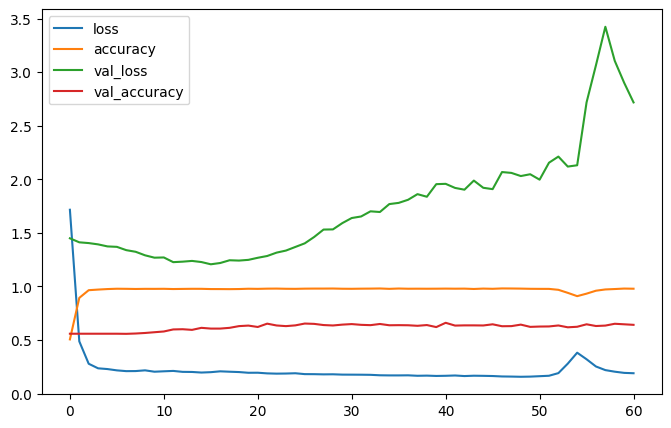

32/32 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           1       0.58      0.71      0.64       159
           2       0.36      0.20      0.25        51
           3       0.22      0.15      0.18        71
           4       0.33      0.21      0.26       163
           5       0.75      0.84      0.80       556

    accuracy                           0.64      1000
   macro avg       0.45      0.42      0.43      1000
weighted avg       0.60      0.64      0.61      1000



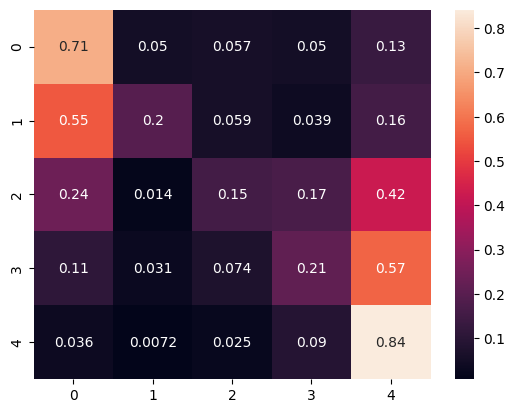

In [60]:
history_to_plot(history)
evaluate_the_model(model, X_test_encoded, y_test)

### c) Experiment on Dropout

[TO STUDENTS]
- Observe the provided results for a dropout ratio of p=0.7 and p=0.3
- What are your conclusions ?
- In the end, considering all the explored settings in this Lab, what would you suggest as a network to get a better model ?

In [61]:
# Design the model function
from keras.layers import Dropout

def build_model_dropout(activation, n_hiddenlayers, hidden_dim, p = 0.5):
     input = Input(shape=(feature_vector_length,), name='input')
     for i in range(n_hiddenlayers):
         if i==0:
             x = Dense(input_shape=(feature_vector_length,), units=hidden_dim, activation=activation, name='layer_'+str(i))(input)
         else:
             x = Dense(input_shape =(hidden_dim,), units=hidden_dim, activation=activation, name='layer_'+str(i))(x)
             x = Dropout(p)(x)
     output = Dense(input_shape =(hidden_dim,), units = n_classes, activation='softmax', name='output')(x)
     model = Model(input, output, name = 'MLP_model')
     return model

In [62]:
#Build and train the network without residual connections
n_hiddenlayers = 5
activation = 'tanh'
hidden_dim = 256
epochs = 100
p = 0.7
model = build_model_dropout(activation, n_hiddenlayers, hidden_dim, p)

# Print the model
model.summary()

Model: "MLP_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 8991)]            0         
                                                                 
 layer_0 (Dense)             (None, 256)               2301952   
                                                                 
 layer_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 layer_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 layer_3 (Dense)             (None, 256)               65

In [63]:
# Configure the model and start training

callbacks_list = [EarlyStopping(monitor='val_accuracy', min_delta=0.0005, patience=20, verbose=1, mode='max', restore_best_weights=True)
 ]

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_encoded, y_train_encoded, validation_data=(X_val_encoded, y_val_encoded),
 epochs=epochs, batch_size=250, callbacks=callbacks_list, verbose=1)

Epoch 1/100
20/20 [==============================] - 2s 44ms/step - loss: 1.4155 - accuracy: 0.4574 - val_loss: 1.1532 - val_accuracy: 0.5740
Epoch 2/100
20/20 [==============================] - 1s 37ms/step - loss: 1.0976 - accuracy: 0.5898 - val_loss: 0.9231 - val_accuracy: 0.6660
Epoch 3/100
20/20 [==============================] - 1s 42ms/step - loss: 0.8690 - accuracy: 0.6754 - val_loss: 0.8983 - val_accuracy: 0.6840
Epoch 4/100
20/20 [==============================] - 1s 40ms/step - loss: 0.7388 - accuracy: 0.7144 - val_loss: 0.9583 - val_accuracy: 0.6800
Epoch 5/100
20/20 [==============================] - 1s 40ms/step - loss: 0.6353 - accuracy: 0.7550 - val_loss: 1.0591 - val_accuracy: 0.6510
Epoch 6/100
20/20 [==============================] - 1s 40ms/step - loss: 0.5544 - accuracy: 0.7888 - val_loss: 1.1640 - val_accuracy: 0.6390
Epoch 7/100
20/20 [==============================] - 1s 41ms/step - loss: 0.5002 - accuracy: 0.8104 - val_loss: 1.2779 - val_accuracy: 0.6500
Epoch 

We decrease the proportion of neurons deactivated at each forward pass, from 0.7 to 0.3

In [64]:
#Build and train the network without residual connections
n_hiddenlayers = 5
activation = 'tanh'
hidden_dim = 256
epochs = 100
p = 0.3
model = build_model_dropout(activation, n_hiddenlayers, hidden_dim, p)

# Print the model
model.summary()
# Configure the model and start training

callbacks_list = [EarlyStopping(monitor='val_accuracy', min_delta=0.0005, patience=20, verbose=1, mode='max', restore_best_weights=True)
 ]

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_encoded, y_train_encoded, validation_data=(X_val_encoded, y_val_encoded),
 epochs=epochs, batch_size=250, callbacks=callbacks_list, verbose=1)

Model: "MLP_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 8991)]            0         
                                                                 
 layer_0 (Dense)             (None, 256)               2301952   
                                                                 
 layer_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 layer_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_13 (Dropout)        (None, 256)               0         
                                                                 
 layer_3 (Dense)             (None, 256)               65

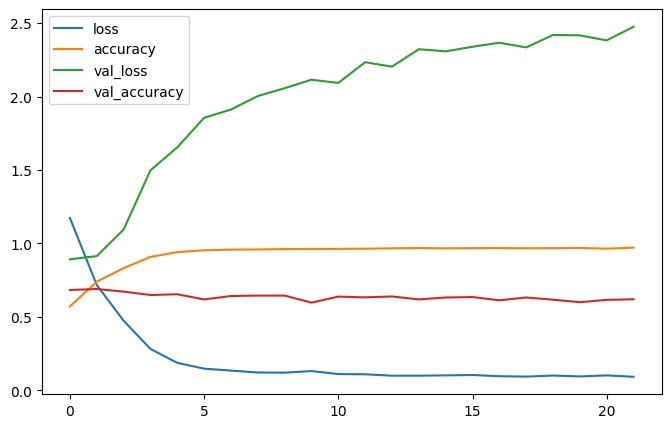

In [65]:
# Plot the learning curves and analyze them
history_to_plot(history)

32/32 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           1       0.59      0.80      0.68       159
           2       1.00      0.04      0.08        51
           3       0.43      0.08      0.14        71
           4       0.37      0.20      0.26       163
           5       0.76      0.92      0.83       556

    accuracy                           0.68      1000
   macro avg       0.63      0.41      0.40      1000
weighted avg       0.65      0.68      0.63      1000



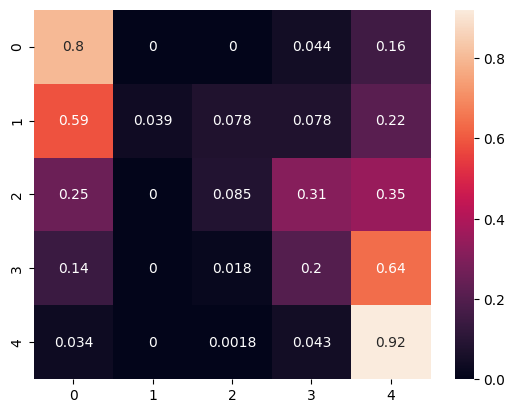

In [66]:
# Evaluate the model
evaluate_the_model(model, X_test_encoded, y_test)